# Projet optimisation de la trajectoire d'un robot

# Partie 1

### Question 1

Les inconnues du problème sont les poses $Pi$ de la trajectoire. On pose $P_{i}=(x_{i},y_{i},\theta_{i})$ avec $x_i,y_i,\theta_i$ définis pour $i$ allant de $0$ à $n$ par rapport à un repère fixe ayant pour origine $P_0 = (0,0,0)$.

On cherche à les déterminer grâce aux relations d'odométrie et de fermeture de boucles qui elles sont connues.


### Question 2

Chaque relation d'odométrie est donnée relativement à la pose précédente. 
On a donc les relations suivantes pour l'odométrie : 

$$
\left\{
    \begin{array}{ll}
        x_{i+1} = x_i + dx_i\cos{\theta_i}- dy_i\sin{}\theta_i = f_{x}(x_{i},dx_{i},dy_{i},\theta_{i})\\
        y_{i+1} = y_i + dx_i\sin{\theta_i}+ dy_i\cos{}\theta_i = f_{y}(y_{i},dx_{i},dy_{i},\theta_{i})\\
        \theta_{i+1} = \theta_i + d\theta_i = f_{\theta}(\theta_{i},d\theta_{i})
    \end{array}
\right.
$$

Et on adapte pour les relations de fermetures de boucle en remplaçant $i+1$ par $j$ avec $j$ l'indice de la fermeture de boucle. 

### Question 3

On veut ici déterminer quelle fonction minimiser afin de vérifier au mieux les données d'odométrie et de fermetures de boucles. On va d'abord introduire plusieurs notations.

On va travailler ici avec des fonctions $f_{x}, f_{y} et f_{\theta}$ définies respectivement par les relations données en question 2 s'appliquant sur les variables $x_{i}, y_{i}$ et $\theta_{i}$. De plus, les éléments que nous appelerons $dx_{i},dy_{i}$ et $d\theta_{i}$ ainsi que $dx'_{i},dy'_{i}$ et $d\theta'_{i}$ dans la suite correspondent respectivement aux valeurs d'odométrie et de fermeture de boucles mesurées par le robot lors de son parcours, et sont donc connues et fixées.

Ce faisant, on note $P_{i}=(x_{i},y_{i},\theta_{i})$ un triplet de $R^{3}$ et M le vecteur de dimension 3n définit par $M=(P_{i})_{1 \leqslant i \leqslant n}$. 

Si M est un minimum de notre fonction, on veut que chacun des $p_{i}$ vérifie au mieux les relations d'odométrie et de fermetures de boucles, c'est-à-dire:

1) $\forall i \in {1,...,n}$,
$x_{i+1}\approx f_{x}(x_{i},dx_{i},dy_{i},\theta_{i})$,
$y_{i+1}\approx f_{y}(y_{i},dx_{i},dy_{i},\theta_{i})$,
$\theta_{i+1}\approx f_{\theta}(\theta_{i},d\theta_{i})$.

2) Si l'on note F l'ensemble des couples (j,i) correspondant à des fermetures de boucles détectées par le robot, on veut également vérifier: $x_{j}\approx f_{x}(x_{i},dx'_{i},dy'_{i},\theta_{i})$, 
$y_{j}\approx f_{y}(y_{i},dx'_{i},dy'_{i},\theta_{i})$ et
$\theta_{j}\approx f_{\theta}(\theta_{i},d\theta'_{i})$.

Plus concrètement, ces approximations se traduisent par le fait que les quantités $\left|x_{i+1}- f_{x}(x_{i},dx_{i},dy_{i},\theta_{i}) \right|^{2}$ soient le plus petites possibles, de même en remplaçant les $x$ par les $y$ et les $\theta$, et de même pour les relations de fermeture de boucle.

Comme on veut que cela soit vrai pour toutes ces relations, et que celles-ci sont interdépendantes, cela revient à minimiser la fonction de $R^{3n}$ suivante:

 $M \in R^{3n} \rightarrow \sum_{i=1}^{n} \left\|P_{i+1} - F(P_{i},dx_{i},dy_{i},d\theta_{i}) \right\|^{2} + \sum_{(j,i) \in F} \left\|P_{j} - F(P_{i},dx'_{i},dy'_{i},d\theta'_{i}) \right\|^{2}$ 

où les $P_{i}$ ont été définis ci-dessus comme les triplets composants de M et où $F(P_{i},dx_{i},dy_{i},d\theta_{i})=(f_{x}(x_{i},dx_{i},dy_{i},\theta_{i}),f_{y}(y_{i},dx_{i},dy_{i},\theta_{i}),f_{\theta}(\theta_{i},d\theta_{i}))$. 

# Partie 2

### Question 1

In [54]:
donnees_odo = []
donnees_loop = []

def recup_donnees(fichier):
    with open(fichier, 'r') as intel:
        for ligne in intel:
            l = ligne.split()
            for i in range(1,len(l)):
                l[i]=float(l[i])
            if l[0]=="EDGE_ODO":
                donnees_odo.append(l[1:3]+[l[3:]])
            else:
                donnees_loop.append(l[1:3]+[l[3:]])
                
recup_donnees("INTEL.txt")
donnees_loop


[[19.0, 166.0, [-2.459689, 0.241111, 0.2528]],
 [19.0, 172.0, [1.067903, 0.915786, 0.14947]],
 [25.0, 172.0, [-2.539634, 0.85263, -0.02986]],
 [25.0, 178.0, [1.225223, 0.672079, -0.10248]],
 [32.0, 178.0, [-2.020007, -0.239771, 0.71518]],
 [32.0, 183.0, [-0.092559, 0.424181, 0.0416]],
 [44.0, 189.0, [-2.265706, -0.570857, 0.19772]],
 [44.0, 195.0, [1.302289, -0.133004, -0.00528]],
 [50.0, 195.0, [-2.374379, -0.253682, 0.21612]],
 [50.0, 201.0, [1.291572, 0.086248, -0.0507]],
 [50.0, 203.0, [2.550695, 0.035722, -0.08465]],
 [61.0, 203.0, [-2.852494, 0.122053, 0.07787]],
 [61.0, 209.0, [0.73078, 0.07297, 0.00889]],
 [67.0, 209.0, [-2.822142, 0.138051, -0.00446]],
 [67.0, 220.0, [0.783704, -1.176736, -1.4129]],
 [81.0, 220.0, [-0.868391, -0.009825, -0.04688]],
 [81.0, 226.0, [2.836453, 0.058719, 0.04915]],
 [87.0, 226.0, [-0.45964, 0.184679, 0.34383]],
 [87.0, 231.0, [1.060624, 0.863823, 0.29401]],
 [94.0, 231.0, [-2.231597, 0.316386, 0.18025]],
 [94.0, 241.0, [2.816677, 0.483252, 0.0414]

### Question 2

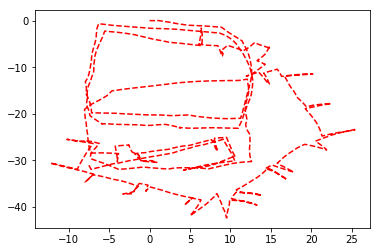

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi

def estim_trajectoire(odometrie):
    liste_x = [0]
    liste_y = [0]
    liste_theta = [0]
    for i in range(len(odometrie)):
        p_i = np.array([liste_x[-1], liste_y[-1], liste_theta[-1]])
        di = np.array(odometrie[i][2])
        rot = np.array([[cos(p_i[2]), -sin(p_i[2]), 0], [sin(p_i[2]),cos(p_i[2]), 0], [0, 0, 1]])
        p_i = p_i + np.dot(rot, di)
        liste_x.append(p_i[0])
        liste_y.append(p_i[1])
        liste_theta.append(p_i[2]%(2*pi))
    return liste_x, liste_y, liste_theta

x, y, t = estim_trajectoire(donnees_odo)
plt.figure()
plt.plot(x, y, 'r--')
plt.show()
        


In [58]:
def F(p_i,di):
    rot = np.array([[cos(p_i[2]), -sin(p_i[2]), 0], [sin(p_i[2]),cos(p_i[2]), 0], [0, 0, 1]])
    p_i = p_i + np.dot(rot, di)
    return p_i
    
def f_minim_pose(P,i):
    #Partie odométrie
    p_i=np.array(P[i])
    pi_1=np.array(P[i+1])
    relations_odo=[]
    if i<len(donnees_odo):
        relations_odo = donnees_odo[i]
    a=(np.linalg.norm(pi_1-F(p_i,np.array(relations_odo[2]))))**2

    #Partie loop
    relations_loop = [item for item in donnees_loop if item[0]==i] #Pas les relations où i est le deuxième indice pour ne pas compter les relations 2 fois
    indexes_loop = [int(item[1]) for item in relations_loop]
    Pj=[np.array(P[j]) for j in indexes_loop]
    for k in range(len(relations_loop)):
        diff=Pj[k]-F(p_i,np.array(relations_loop[k][2]))
        diff[2]=diff[2]%(2*pi)
        diff[2]= min(diff[2],2*pi-diff[2])
        print(diff[2])
        a+=np.linalg.norm(diff)**2
        
    #print(a)
    return a

def f_minim(P):
    return sum([f_minim_pose(P,i) for i in range(len(donnees_odo))])

P=np.array([[x[i],y[i],t[i]] for i in range(len(x))])
P[19][2]=0
f_minim(P)

"""liste_theta=np.linspace(-2*pi,2*pi,200)
liste_f=[]
for i in range(200):
    P[19][2]=liste_theta[i]
    liste_f.append(f_minim(P))
    
plt.figure()
plt.plot(liste_theta, liste_f, 'b--')
plt.show()"""

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
43.59645282312098
855.0494035027389
0.0
0.0
0.0
0.0
0.0
1337.857609110776
0.0
0.0
0.0
0.0
0.0
0.0
1753.1826676540618
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
552.1070958443518
0.0
0.0
0.0
0.0
0.0
320.7596633566495
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
323.6707030853607
0.0
0.0
0.0
0.0
0.0
856.4156567948776
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1116.8859849838698
0.0
0.0
0.0
0.0
0.0
886.2144077621131
0.0
0.0
0.0
0.0
0.0
0.0
1781.6825993292164
0.0
0.0
0.0
0.0
0.0
0.0
4193.963819867214
0.0
0.0
0.0
0.0
0.0
7331.7562210004735
0.0
0.0
0.0
0.0
0.0
0.0
6350.869979307321
0.0
0.0
0.0
0.0
0.0
0.0
3376.1999717375943
0.0
0.0
0.0
0.0
3132.485799024859
0.0
0.0
0.0
0.0
0.0
4987.643571607407
0.0
0.0
0.0
0.0
0.0
5853.941050693495
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5147.373042357608
0.0
0.0
0.0
0.0
0.0
1474.5639112320357
0.0
0.0
0.0
0.0
0.0
1452.6691866876658
0.0
0.0
1276.8302899337975
0.0
0.0
0.0
0.0


"liste_theta=np.linspace(-2*pi,2*pi,200)\nliste_f=[]\nfor i in range(200):\n    P[19][2]=liste_theta[i]\n    liste_f.append(f_minim(P))\n    \nplt.figure()\nplt.plot(liste_theta, liste_f, 'b--')\nplt.show()"